# **1 . DATASET**

**Download library**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

**Import library**

In [ ]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
import cv2
from PIL import Image
import json
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**Unzip Dataset BTXRD**

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/BTXRD.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

# **2. PREPROCESSING**

2.1 Import

In [ ]:
import os
import json
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from shapely.geometry import Polygon
import albumentations as A
import shutil
from tqdm import tqdm


 2.2 Define paths and class list

In [ ]:
# Đường dẫn
input_images_dir = "/content/BTXRD/images"
input_annotations_dir = "/content/BTXRD/Annotations"
output_base_dir = "/content/BTXRD_YOLO"

# Danh sách class
class_names = [
    "osteochondroma",
    "synovial osteochondroma",
    "osteofibroma",
    "simple bone cyst",
    "other bt",
    "other mt",
    "multiple osteochondromas",
    "osteosarcoma",
    "giant cell tumor"
]
label_map = {name.lower(): idx for idx, name in enumerate(class_names)}

# Xóa output cũ nếu có
if os.path.exists(output_base_dir):
    shutil.rmtree(output_base_dir)
    print(f"Đã xóa {output_base_dir}")

# Tạo thư mục output mới
for split in ['train', 'val']:
    os.makedirs(f"{output_base_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_base_dir}/labels/{split}", exist_ok=True)

2.3 Helper functions for polygon and image finding

In [ ]:
def order_polygon(norm_pts):
    if len(norm_pts) < 3:
        return norm_pts
    try:
        poly = Polygon(norm_pts)
        if not poly.is_valid or poly.is_empty:
            return norm_pts
        return list(poly.exterior.coords)[:-1]
    except Exception as e:
        print(f"[!] Lỗi polygon: {e}")
        return norm_pts

def find_image_for_json(json_path):
    base = os.path.splitext(os.path.basename(json_path))[0]
    for ext in ['.jpg', '.jpeg', '.png']:
        candidate = os.path.join(input_images_dir, base + ext)
        if os.path.exists(candidate):
            return candidate, base + ext
    return None, None


2.4 Create masks and YOLO format labels

In [ ]:
def create_mask_from_polygon(image_shape, polygons_with_cls, mask_output_path):
    """
    Tạo mask từ polygons và lưu dưới dạng file PNG.
    image_shape: Kích thước ảnh (height, width)
    polygons_with_cls: Danh sách các polygon với lớp
    mask_output_path: Đường dẫn để lưu ảnh mask
    """
    h, w = image_shape
    mask = np.zeros((h, w), dtype=np.uint8)

    for pts, _ in polygons_with_cls:
        # Chuyển polygon thành contour (vị trí của các điểm polygon)
        pts = np.array(pts, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 255)  # Fill mask với giá trị 255 tại các polygon

    # Lưu ảnh mask dưới định dạng PNG
    cv2.imwrite(mask_output_path, mask)


def convert_to_yolo_format(image_shape, polygons_with_cls, label_output_path, mask_output_path):
    """
    Chuyển đổi polygon sang định dạng YOLOv5 Seg (bao gồm mask).
    """
    # Define h and w within this function scope
    h, w = image_shape

    # Tạo mask và lưu
    create_mask_from_polygon(image_shape, polygons_with_cls, mask_output_path)

    # Nếu bạn muốn tạo file label cho YOLOv5, bạn có thể giữ phần này như cũ.
    label_lines = []
    for pts, cls_id in polygons_with_cls:
        # Now w and h are defined
        norm_pts = [(x / w, y / h) for x, y in pts]
        norm_pts = order_polygon(norm_pts)
        if len(norm_pts) < 3:
            continue
        flat = [f"{x:.6f}" for pt in norm_pts for x in pt]
        line = f"{cls_id} " + " ".join(flat)
        label_lines.append(line)

    # Lưu file label dưới dạng .txt (đối với YOLOv5 Seg, label có thể không cần thiết nếu bạn sử dụng mask).
    with open(label_output_path, 'w') as f:
        f.write("\n".join(label_lines))

2.5 Image and polygon augmentation

In [ ]:
def augment_image_and_polygons(image, polygons_with_cls):
    h, w = image.shape[:2]
    keypoints = []
    lengths = []
    cls_ids = []

    for poly, cls_id in polygons_with_cls:
        lengths.append(len(poly))
        cls_ids.append(cls_id)
        for x, y in poly:
            keypoints.append((int(x), int(y)))

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=25, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5)
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    try:
        augmented = transform(image=image, keypoints=keypoints)
    except:
        return None, None

    aug_image = augmented["image"]
    aug_kps = augmented["keypoints"]

    new_polygons = []
    idx = 0
    for i, l in enumerate(lengths):
        poly = aug_kps[idx:idx+l]
        idx += l
        if len(poly) >= 3:
            new_polygons.append((poly, cls_ids[i]))
    return aug_image, new_polygons


2.6 Process annotation JSON files

In [ ]:
def process_jsons(json_list, split, augment=False, augment_times=2):
    for json_path in tqdm(json_list, desc=f"Processing {split} (positive)"):
        img_path, _ = find_image_for_json(json_path)
        if img_path is None:
            print(f"[!] Không tìm thấy ảnh cho {json_path}")
            continue
        img = cv2.imread(img_path)
        if img is None:
            print(f"[!] Không đọc được ảnh {img_path}")
            continue

        with open(json_path) as f:
            data = json.load(f)

        polygons_cls = []
        for shape in data.get("shapes", []):
            label = shape.get("label", "").lower().strip()
            if label not in label_map:
                print(f"[!] Label lạ: {label}")
                continue
            class_id = label_map[label]
            shape_type = shape.get("shape_type", "polygon")

            if shape_type != "polygon":
                continue

            pts = shape.get("points", [])
            if len(pts) < 3:
                continue

            polygons_cls.append((pts, class_id))

        name = os.path.splitext(os.path.basename(json_path))[0]
        out_img = os.path.join(output_base_dir, "images", split, name + ".jpg")
        out_lbl = os.path.join(output_base_dir, "labels", split, name + ".txt")
        out_mask = os.path.join(output_base_dir, "labels", split, name + ".png")

        cv2.imwrite(out_img, img)
        convert_to_yolo_format(img.shape[:2], polygons_cls, out_lbl, out_mask)

        if augment and polygons_cls:
            for i in range(augment_times):
                aug_img, aug_polys = augment_image_and_polygons(img, polygons_cls)
                if aug_img is None:
                    continue
                aug_name = f"{name}_aug{i}"
                cv2.imwrite(os.path.join(output_base_dir, "images", split, aug_name + ".jpg"), aug_img)
                convert_to_yolo_format(aug_img.shape[:2], aug_polys,
                                       os.path.join(output_base_dir, "labels", split, aug_name + ".txt"),
                                       os.path.join(output_base_dir, "labels", split, aug_name + ".png"))


2.7 Add negative samples (no annotations)

In [ ]:
def copy_negative_images(base_names, split):
    print(f"🔍 Thêm ảnh không có annotation vào tập {split}...")
    for base in tqdm(base_names, desc=f"Copy negatives to {split}"):
        for ext in ['.jpg', '.jpeg', '.png']:
            img_path = os.path.join(input_images_dir, base + ext)
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    out_img = os.path.join(output_base_dir, "images", split, base + ".jpg")
                    out_lbl = os.path.join(output_base_dir, "labels", split, base + ".txt")
                    out_mask = os.path.join(output_base_dir, "labels", split, base + ".png")
                    cv2.imwrite(out_img, img)
                    with open(out_lbl, 'w') as f:
                        f.write("")  # File label trống cho ảnh không có annotations
                    mask = np.zeros_like(img[:, :, 0], dtype=np.uint8)
                    cv2.imwrite(out_mask, mask)  # Mask trống
                break


2.8 Run processing

In [ ]:

# Phân loại ảnh có và không có annotation
all_image_files = sorted(glob(os.path.join(input_images_dir, '*')))
all_image_bases = [os.path.splitext(os.path.basename(p))[0] for p in all_image_files]
all_json_bases = [os.path.splitext(os.path.basename(p))[0] for p in glob(os.path.join(input_annotations_dir, '*.json'))]

positive_bases = list(set(all_json_bases) & set(all_image_bases))
negative_bases = list(set(all_image_bases) - set(positive_bases))

# Chia tập train/val cho cả ảnh dương tính và âm tính
train_pos, val_pos = train_test_split(positive_bases, test_size=0.2, random_state=42)
train_neg, val_neg = train_test_split(negative_bases, test_size=0.2, random_state=42)

train_jsons = [os.path.join(input_annotations_dir, b + ".json") for b in train_pos]
val_jsons = [os.path.join(input_annotations_dir, b + ".json") for b in val_pos]

# Xử lý ảnh có annotation
process_jsons(train_jsons, "train", augment=True, augment_times=1)
process_jsons(val_jsons, "val", augment=False)

# Xử lý ảnh không có annotation
copy_negative_images(train_neg, "train")
copy_negative_images(val_neg, "val")

print("✅ Xử lý hoàn tất.")

Processing val (positive): 100%|██████████| 374/374 [00:13<00:00, 26.92it/s]


🔍 Thêm ảnh không có annotation vào tập train...


Copy negatives to train: 100%|██████████| 1503/1503 [01:12<00:00, 20.68it/s]


🔍 Thêm ảnh không có annotation vào tập val...


Copy negatives to val: 100%|██████████| 376/376 [00:19<00:00, 19.77it/s]

✅ Xử lý hoàn tất.


# **3.BALANCE DATASET**

3.1 Count Label Distribution per Class

In [ ]:
from collections import defaultdict

def count_classes(label_dir, class_names):
    class_counts = defaultdict(int)
    image_counts = defaultdict(set)

    label_files = glob(os.path.join(label_dir, '*.txt'))
    for label_file in label_files:
        with open(label_file, 'r') as f:
            lines = f.readlines()
            used_classes = set()
            for line in lines:
                if line.strip() == "":
                    continue  # Skip empty
                parts = line.strip().split()
                cls_id = int(parts[0])
                used_classes.add(cls_id)
            for cls_id in used_classes:
                class_counts[cls_id] += 1
                image_counts[cls_id].add(os.path.basename(label_file))

    print(f"\n📊 Statistics for {label_dir}:")
    for cls_id, count in class_counts.items():
        print(f"- {class_names[cls_id]} ({cls_id}): {count} images")

# Kiểm tra train
count_classes(os.path.join(output_base_dir, "labels/train"), class_names)

# Kiểm tra val
count_classes(os.path.join(output_base_dir, "labels/val"), class_names)



📊 Statistics for /content/BTXRD_YOLO/labels/train:
- other bt (4): 192 images
- multiple osteochondromas (6): 420 images
- simple bone cyst (3): 340 images
- osteochondroma (0): 1188 images
- other mt (5): 76 images
- osteosarcoma (7): 468 images
- osteofibroma (2): 70 images
- synovial osteochondroma (1): 88 images
- giant cell tumor (8): 144 images

📊 Statistics for /content/BTXRD_YOLO/labels/val:
- osteofibroma (2): 9 images
- osteosarcoma (7): 63 images
- osteochondroma (0): 159 images
- simple bone cyst (3): 36 images
- multiple osteochondromas (6): 53 images
- giant cell tumor (8): 21 images
- synovial osteochondroma (1): 7 images
- other bt (4): 19 images
- other mt (5): 7 images


3.2 Map Classes to Associated Label Files

In [ ]:
from collections import defaultdict

def get_class_distribution(label_dir):
    class_to_images = defaultdict(set)
    label_files = glob(os.path.join(label_dir, "*.txt"))
    for label_file in label_files:
        with open(label_file) as f:
            for line in f:
                if line.strip():
                    cls_id = int(line.strip().split()[0])
                    class_to_images[cls_id].add(label_file)
    return class_to_images


3.3 Balance Class

In [ ]:
def balance_classes(train_label_dir, train_image_dir, max_class_size=500, max_total_aug=5000):
    class_to_images = get_class_distribution(train_label_dir)
    total_augmented = 0

    for cls_id, label_paths in class_to_images.items():
        label_paths = list(label_paths)
        current_count = len(label_paths)
        if current_count >= max_class_size:
            continue  # Đã đủ ảnh

        needed = max_class_size - current_count

        # Giới hạn augment tổng tối đa
        if total_augmented + needed > max_total_aug:
            needed = max_total_aug - total_augmented
        if needed <= 0:
            break

        print(f"[+] Augmenting class {class_names[cls_id]} ({cls_id}): need {needed} more images")

        i = 0
        while needed > 0:
            label_file = label_paths[i % len(label_paths)]
            base_name = os.path.splitext(os.path.basename(label_file))[0]
            image_path = os.path.join(train_image_dir, base_name + ".jpg")
            if not os.path.exists(image_path):
                i += 1
                continue

            img = cv2.imread(image_path)
            polygons = []
            with open(label_file) as f:
                for line in f:
                    parts = line.strip().split()
                    cid = int(parts[0])
                    if cid != cls_id:
                        continue
                    pts = list(map(float, parts[1:]))
                    polygon = [(pts[i]*img.shape[1], pts[i+1]*img.shape[0]) for i in range(0, len(pts), 2)]
                    polygons.append((polygon, cid))

            if not polygons:
                i += 1
                continue

            aug_img, aug_polys = augment_image_and_polygons(img, polygons)
            if aug_img is None or not aug_polys:
                i += 1
                continue

            aug_name = f"{base_name}_bal_{i}"
            out_img_path = os.path.join(train_image_dir, aug_name + ".jpg")
            out_lbl_path = os.path.join(train_label_dir, aug_name + ".txt")
            out_mask_path = os.path.join(train_label_dir, aug_name + ".png") # Define mask output path

            cv2.imwrite(out_img_path, aug_img)
            convert_to_yolo_format(aug_img.shape[:2], aug_polys, out_lbl_path, out_mask_path) # Add mask_output_path

            needed -= 1
            total_augmented += 1
            i += 1
            if total_augmented >= max_total_aug:
                print("[!] Reached max total augmentation limit")
                break

3.4 Run Balance Dataset

In [ ]:
# Augment bổ sung để cân bằng class trong tập train
balance_classes(
    os.path.join(output_base_dir, "labels/train"),
    os.path.join(output_base_dir, "images/train"),
    max_class_size=300
)

[+] Augmenting class other bt (4): need 108 more images
[+] Augmenting class other mt (5): need 224 more images
[+] Augmenting class osteofibroma (2): need 230 more images
[+] Augmenting class synovial osteochondroma (1): need 212 more images
[+] Augmenting class giant cell tumor (8): need 156 more images


# **4 . TRAINING MODEL YOLOV8NANO - SEGMENT**

In [ ]:
model = YOLO('yolov8n-seg.pt')

history = model.train(
    data='/content/data.yaml',
    epochs=50,
    imgsz=640,
    batch=64,
    name='btxrd_yolo_segment',
    # --- Augmentation Parameters ---
    flipud=0.5,  # Up-down flip 50%
    fliplr=0.5,  # Left-right flip 50%
)

100%|██████████| 6.74M/6.74M [00:00<00:00, 259MB/s]


Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=btxrd_yolo_segment, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

100%|██████████| 755k/755k [00:00<00:00, 104MB/s]

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n-seg summary: 151 layers, 3,265,371 parameters, 3,265,355 gradients, 12.1 GFLOPs

Transferred 381/417 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 292MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1404.8±569.0 MB/s, size: 202.8 KB)


train: Scanning /content/BTXRD_YOLO/labels/train... 5419 images, 1503 backgrounds, 6 corrupt: 100%|██████████| 5419/5419 [00:03<00:00, 1586.24it/s]

train: /content/BTXRD_YOLO/images/train/IMG000149_aug0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0059]
train: /content/BTXRD_YOLO/images/train/IMG000925_bal_93.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0049]
train: /content/BTXRD_YOLO/images/train/IMG001009_aug0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0224]
train: /content/BTXRD_YOLO/images/train/IMG001055_aug0.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0455]
train: /content/BTXRD_YOLO/images/train/IMG001374_aug0.jpg: ignoring corrupt image/label: negative label values [  -0.034651]
train: /content/BTXRD_YOLO/images/train/IMG001787_aug0_bal_10.jpg: ignoring corrupt image/label: negative label values [  -0.011157]


train: New cache created: /content/BTXRD_YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1745.4±753.7 MB/s, size: 200.4 KB)


val: Scanning /content/BTXRD_YOLO/labels/val... 750 images, 376 backgrounds, 0 corrupt: 100%|██████████| 750/750 [00:00<00:00, 1385.94it/s]

val: New cache created: /content/BTXRD_YOLO/labels/val.cache


Plotting labels to runs/segment/btxrd_yolo_segment/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/btxrd_yolo_segment
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.33G      2.243      3.997      6.289      1.967         80        640:  27%|██▋       | 23/85 [00:20<00:56,  1.11it/s]
Exception in thread Thread-22 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/multiprocessing/reduct

KeyboardInterrupt: 

# **5 . TEST MODEL**

UNZIP VALIDATION 200 IMAGES

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/BTXRD (3).zip", 'r')
zip_ref.extractall("/content/BTXRD")
zip_ref.close()

In [ ]:
from ultralytics import YOLO
import os
from glob import glob
import cv2
import shutil
import numpy as np

# Load model đã train
model = YOLO('/content/best.pt')

# Folder chứa ảnh val
val_img_dir = '/content/BTXRD/BTXRD/val'

# Folder lưu ảnh kết quả predict (có mask + bbox)
output_dir = '/content/predictions_val'

# Thư mục kết quả cụ thể bên trong output_dir
results_dir = os.path.join(output_dir, 'results')

# Kích thước ảnh mong muốn khi predict (YOLO sẽ resize tự động)
target_imgsz = 640

# Xóa thư mục cũ nếu tồn tại
if os.path.exists(results_dir):
    print(f"Đang xóa thư mục cũ: {results_dir}")
    shutil.rmtree(results_dir)
    print("Đã xóa.")

# Tạo lại thư mục output (chỉ tạo thư mục cha, model.predict sẽ tạo thư mục 'results')
os.makedirs(output_dir, exist_ok=True)

# Lấy danh sách ảnh val
image_paths = glob(os.path.join(val_img_dir, '*.jpeg'))

print(f"Bắt đầu dự đoán trên {len(image_paths)} ảnh từ thư mục: {val_img_dir}")

if not image_paths:
    print("Không tìm thấy ảnh nào để xử lý.")
else:
    results = model.predict(
        source=val_img_dir, # Pass the directory path as source
        save=True,
        save_txt=True,
        save_conf=True,
        conf=0.3,
        imgsz=target_imgsz, # Specify the image size for prediction
        project=output_dir,
        name='results',
        exist_ok=True,
        verbose=True
    )

    print(f"Đã hoàn thành dự đoán. Kết quả được lưu trong thư mục: {output_dir}/results")

Bắt đầu dự đoán trên 200 ảnh từ thư mục: /content/BTXRD/BTXRD/val

image 1/200 /content/BTXRD/BTXRD/val/IMG000024.jpeg: 640x544 1 osteosarcoma, 70.3ms
image 2/200 /content/BTXRD/BTXRD/val/IMG000030.jpeg: 640x544 1 other mt, 8.8ms
image 3/200 /content/BTXRD/BTXRD/val/IMG000032.jpeg: 640x544 1 other mt, 8.8ms
image 4/200 /content/BTXRD/BTXRD/val/IMG000033.jpeg: 640x320 1 osteosarcoma, 69.6ms
image 5/200 /content/BTXRD/BTXRD/val/IMG000044.jpeg: 640x416 1 osteosarcoma, 69.8ms
image 6/200 /content/BTXRD/BTXRD/val/IMG000045.jpeg: 640x416 2 osteosarcomas, 8.5ms
image 7/200 /content/BTXRD/BTXRD/val/IMG000049.jpeg: 640x640 1 other mt, 1 osteosarcoma, 10.8ms
image 8/200 /content/BTXRD/BTXRD/val/IMG000050.jpeg: 576x640 1 osteosarcoma, 69.2ms
image 9/200 /content/BTXRD/BTXRD/val/IMG000052.jpeg: 640x416 1 osteosarcoma, 9.1ms
image 10/200 /content/BTXRD/BTXRD/val/IMG000055.jpeg: 640x544 1 osteosarcoma, 9.3ms
image 11/200 /content/BTXRD/BTXRD/val/IMG000057.jpeg: 640x448 1 osteosarcoma, 68.8ms
image 1

# **RESULT**

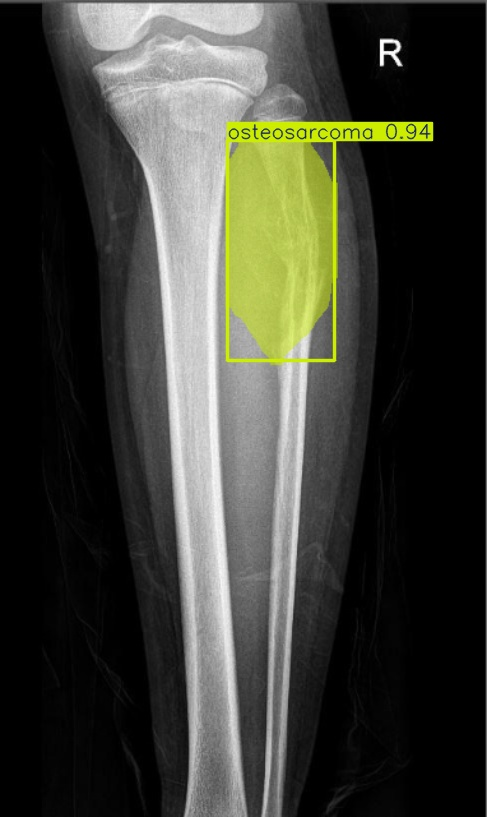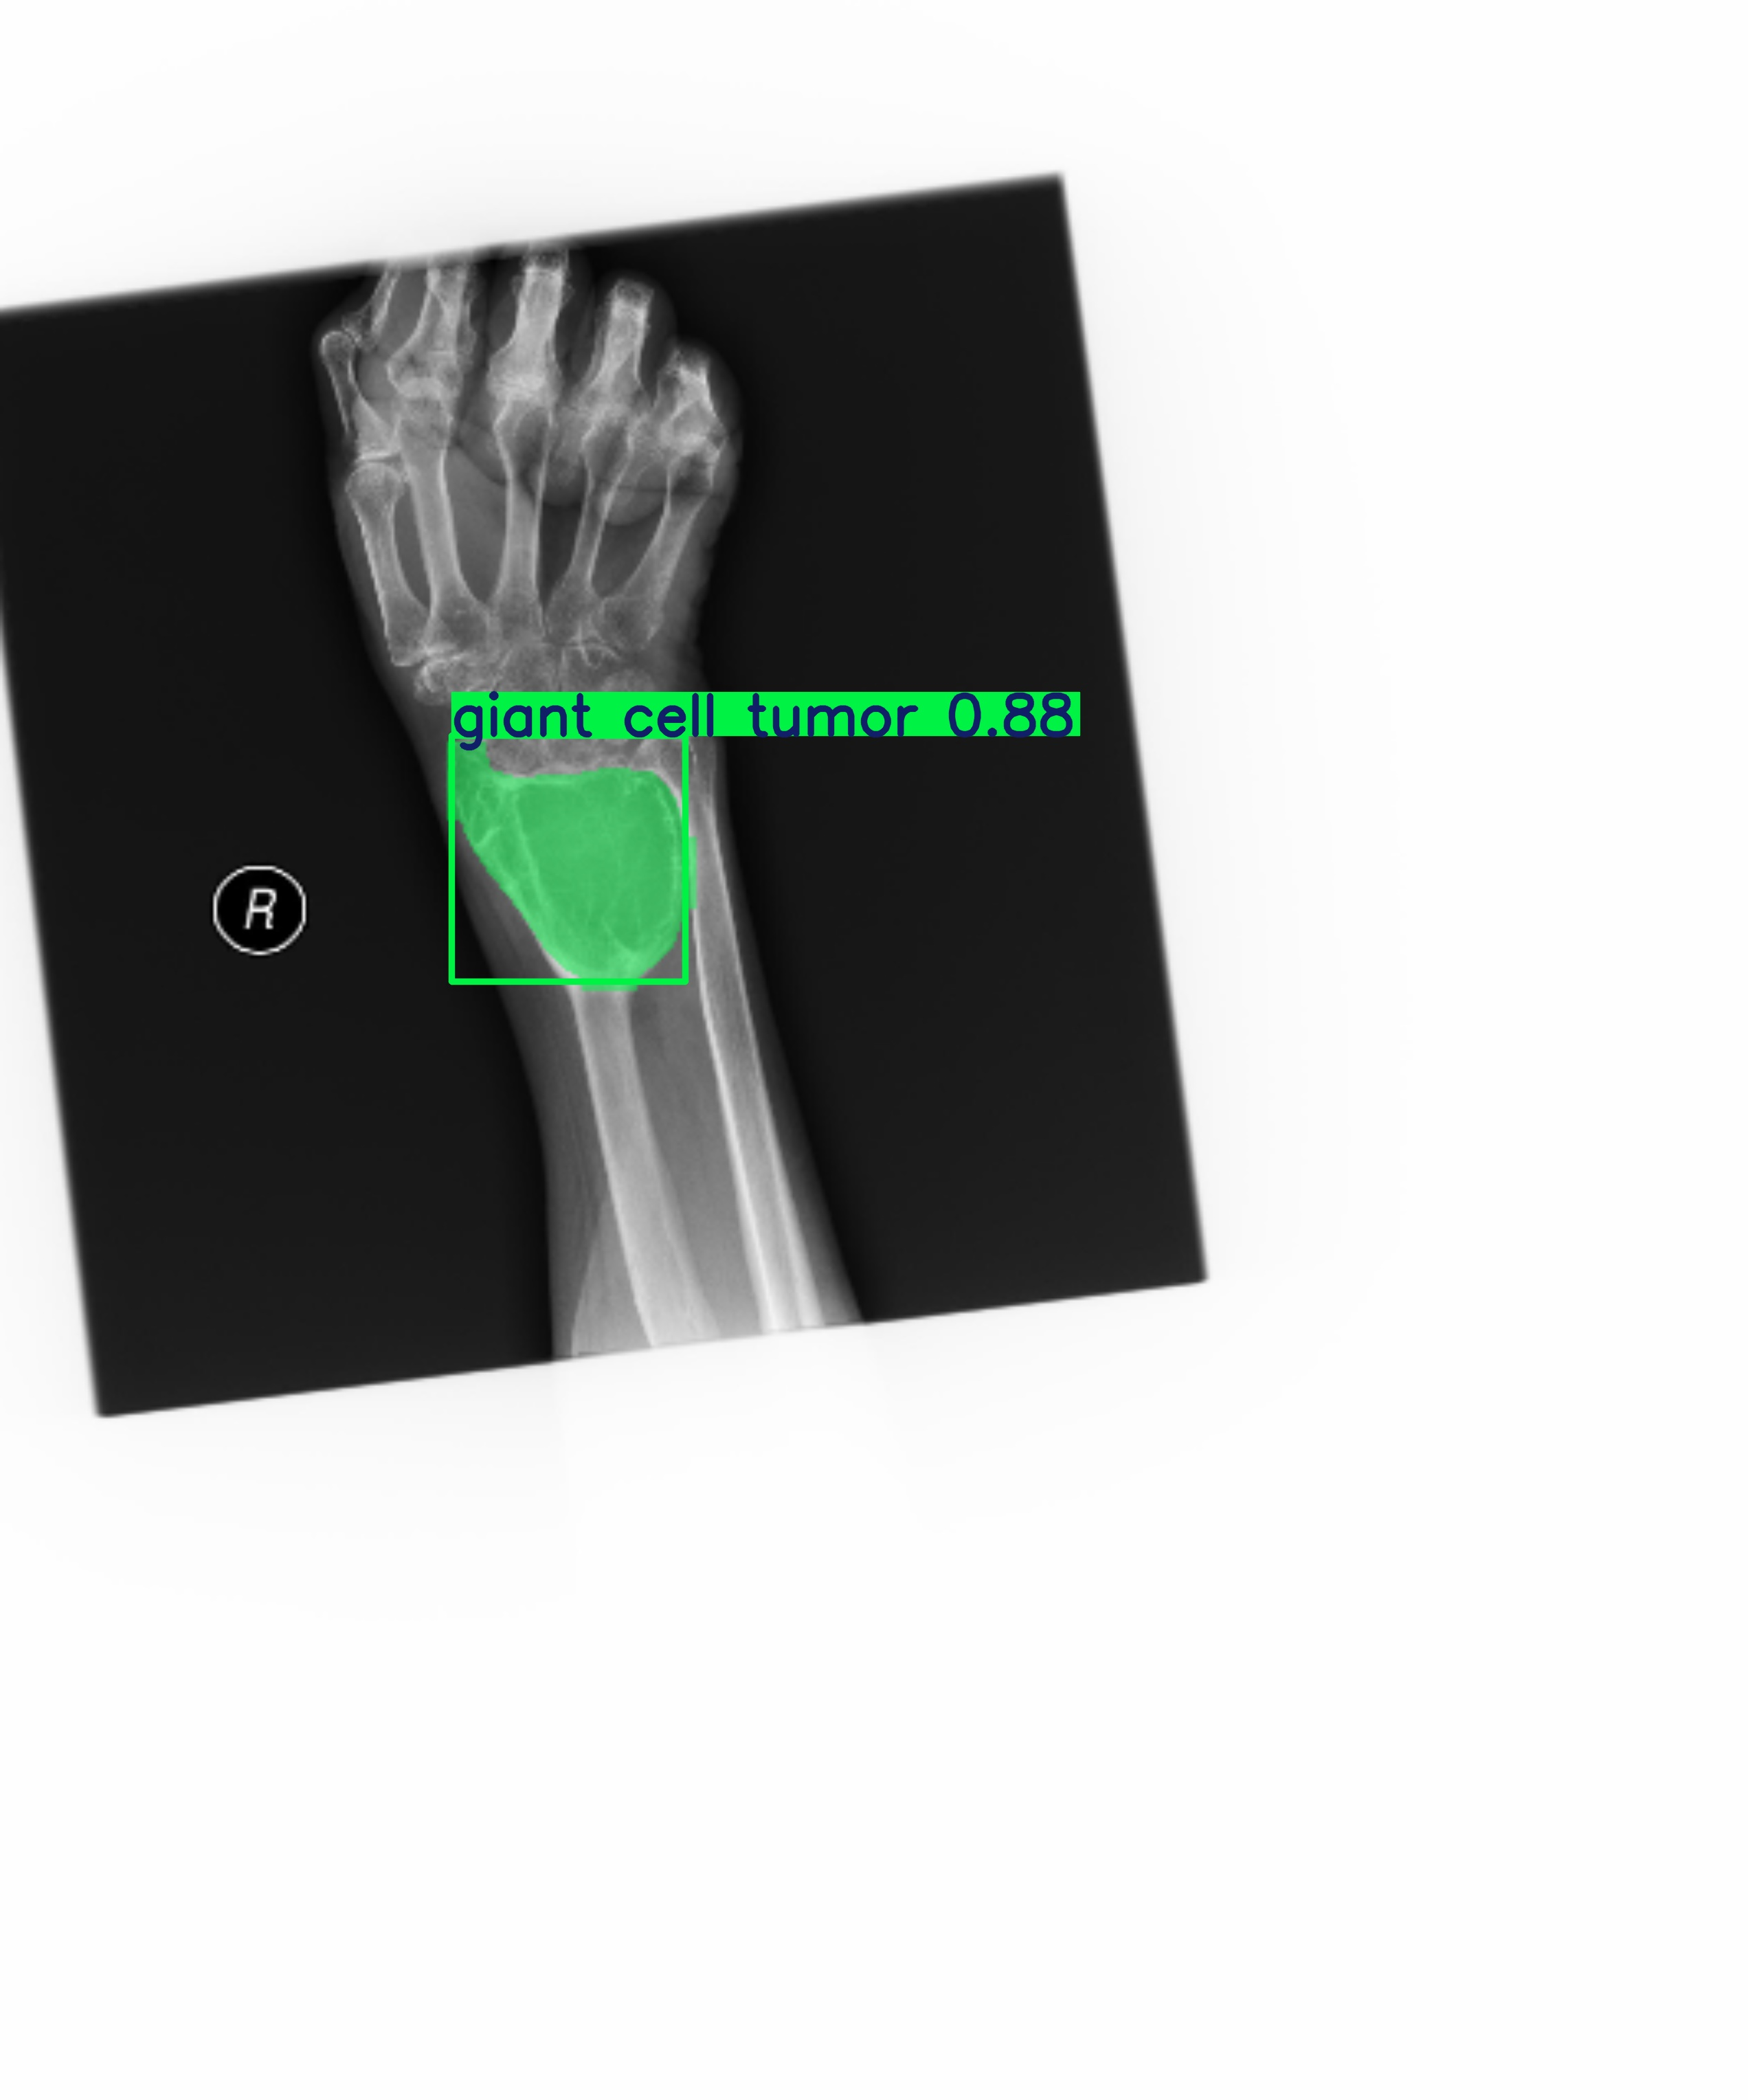

# **6. TEST MODEL TFLITE**


In [ ]:
!python /content/main.py

E0000 00:00:1749479064.142307   14411 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749479064.148104   14411 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/content/BTXRD/BTXRD//val//IMG000967.jpeg
/content/BTXRD/BTXRD//val//IMG000744.jpeg
/content/BTXRD/BTXRD//val//IMG000241.jpeg
/content/BTXRD/BTXRD//val//IMG000066.jpeg
/content/BTXRD/BTXRD//val//IMG000426.jpeg
/content/BTXRD/BTXRD//val//IMG000788.jpeg
/content/BTXRD/BTXRD//val//IMG000731.jpeg
/content/BTXRD/BTXRD//val//IMG000747.jpeg
/content/BTXRD/BTXRD//val//IMG000994.jpeg
/content/BTXRD/BTXRD//val//IMG000625.jpeg
/content/BTXRD/BTXRD//val//IMG000529.jpeg
/content/BTXRD/BTXRD//val//IMG000579.jpeg
/content/BTXRD/BTXRD//val//IMG000271.jpeg
/content/BTXRD/BTXRD//val//IMG000222.jpeg
/co